# How to use my likelihood calculator

Ben Pennell

--

Max Planck Institut für Astronomie, Heidelberg
_____

In [1]:
import numpy as np
import Forward as f
import GaiamockWrapper as gw
import pickle

import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 10)

/home/bepennell/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


let's create an object using `gaiamock` and then see if we can constrain some of the parameters

In [2]:
catpath = "data/gaia_catalogue_with_masses.pkl"
r = pickle.load(open(catpath, "rb"))

In [3]:
set_objs = gw.generate_mock_data(sample_count=10, p_model=(f.calculate_p_distribution, (5,3)), catalogue_with_masses=r, binary_fraction=1, eccentricity=f.calculate_e_distribution)

precomputing all orbital parameters...
calculating astrometric signals...


  0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
set_objs

array([{'ra': 271.6513199849765, 'dec': 32.518488923668606, 'parallax': 20.39701881065626, 'iso_mass': 0.5, 'phot_g_mean_mag': 12.463714599609375, 'is_binary': True, 'solution_type': 7, 'acceleration7': 1.3608375799455248, 'acceleration9': 1.379898761200612, 'jerk': 0.6147837987236517, 'period': 5858.248200152536, 'eccentricity': 0.95, 'mass_ratio': 0.8782620435180459, 'inclination': 1.266715856340406, 'omega': 1.5418786749016269, 'Omega': 5.9181526674639935, 't_periastron': 1388.2173268476477, 'ruwe': 2.365995753821561},
       {'ra': 43.10403111906469, 'dec': -32.97523779012858, 'parallax': 19.730706032480448, 'iso_mass': 0.446, 'phot_g_mean_mag': 13.436412811279297, 'is_binary': True, 'solution_type': 12, 'acceleration7': 33.94273595055022, 'acceleration9': 31.48175119239363, 'jerk': 78.98373458308872, 'period': 1111.849604819271, 'eccentricity': 0.31666666666666665, 'mass_ratio': 0.9332163310688545, 'inclination': 1.3903230628488792, 'omega': 2.108612320636258, 'Omega': 5.403843637

In [6]:
target_object = set_objs[0]

I've chosen this object. I can now try and constrain the allowed parameters. How this will work is at each RUWE step, it will calculate a distribution of RUWEs considering the noise and marginalised parameters. Then it will determine how often you are within $5\%$ of the correct RUWE value.

In principle I could also see a scheme where you try to minimise the "distance" between the estimated signals and the catalogue ones, instead of the likelihood. This might also be faster. I could implement this if desired.

In [7]:
target_object

{'ra': 271.6513199849765,
 'dec': 32.518488923668606,
 'parallax': 20.39701881065626,
 'iso_mass': 0.5,
 'phot_g_mean_mag': 12.463714599609375,
 'is_binary': True,
 'solution_type': 7,
 'acceleration7': 1.3608375799455248,
 'acceleration9': 1.379898761200612,
 'jerk': 0.6147837987236517,
 'period': 5858.248200152536,
 'eccentricity': 0.95,
 'mass_ratio': 0.8782620435180459,
 'inclination': 1.266715856340406,
 'omega': 1.5418786749016269,
 'Omega': 5.9181526674639935,
 't_periastron': 1388.2173268476477,
 'ruwe': 2.365995753821561}

In [9]:
my_binary = f.Binary(df=target_object, catalogue_position=True, 
                    m1=target_object["iso_mass"], parallax=target_object["parallax"], ecc=0.95, # 'known' values
                    Tp=gw.random_Tp, w=gw.random_angle, omega=gw.random_angle, # marginalised parameters
                    period={"prior":(1,8)}, q={"prior":(0.01,1)}, inc={"prior":(0,np.pi/2)}) # values to 'constrain'

In [10]:
my_binary.constrain_parameters(step_count=1000, nwalkers=8, ruwe_sample_count=30)

100%|██████████| 1000/1000 [06:42<00:00,  2.48it/s]


let's see how the mcmc 'burn in' took

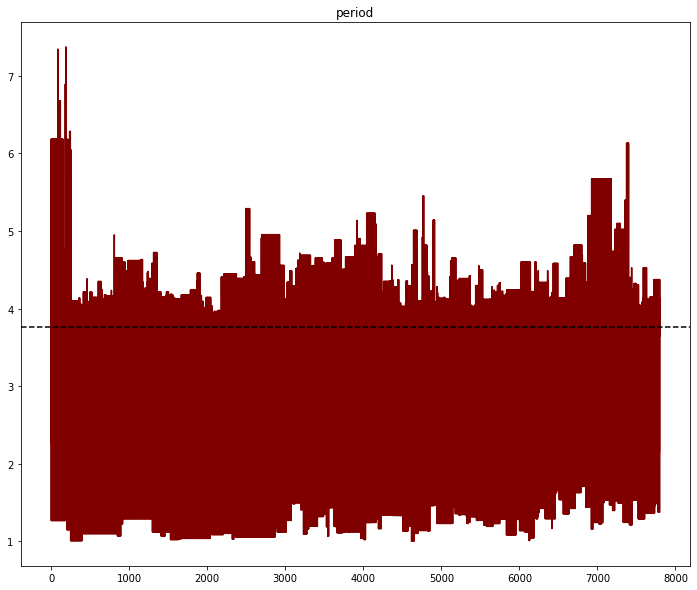

In [11]:
my_binary.plot_parameter("period", truth=np.log10(target_object["period"]))

seems like 500/6 should do

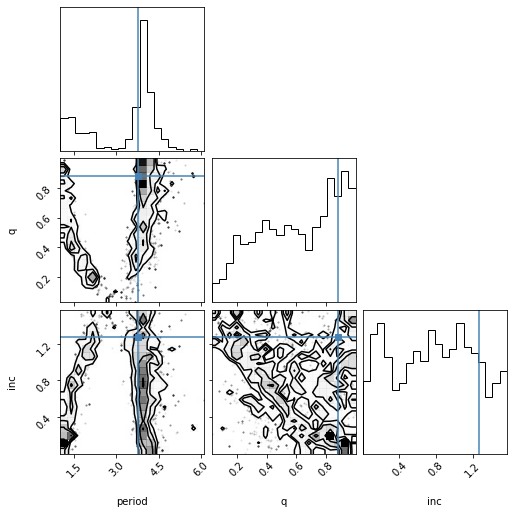

In [15]:
my_binary.plot_corner(truths=[np.log10(target_object["period"]), target_object["mass_ratio"], target_object["inclination"]], 
                      discard=80);

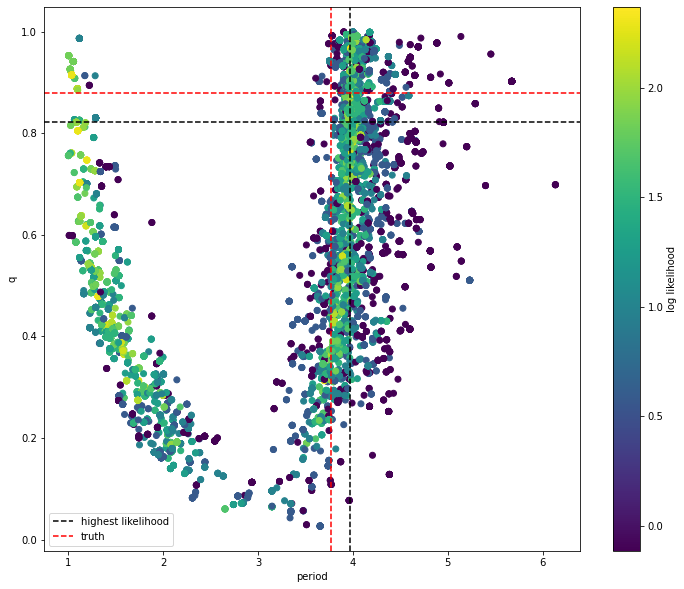

In [16]:
my_binary.plot_2d(["period", "q"], truths=[np.log10(target_object["period"]), target_object["mass_ratio"]], discard=60);

it's doing alright.

further: you can save the constraining that you've done with

`my_binary.save_results(save_dir="./data", name="binary", note="marginalised orbital angles, constrained p,q,inc")`

and then load a saved object like

`my_binary = f.Catalogue(load="./data/binary.pkl")`

from which you can make plots, constrain parameters, etc.

there's a lot more little features I have here, you can ask if there's anything else you want to accomplish.